In [2]:
# set the random seed for reproducibility
import random
import dotenv
import pathlib
import os
random.seed(2024)
dotenv.load_dotenv(override=True)
HOME_DIR = os.getenv("HOME_DIR")
print(HOME_DIR)

/home/csverst/Github/InterpretabilityBenchmark/


# Introduction to the Computation-Thru-Dynamics Benchmark
Hello! Welcome to the Computation-Thru-Dynamics Benchmark! In this tutorial, we'll be walking through the major features of CtD and how you can use it to test the ability of your data-trained models to accurately capture the dynamics of task-trained models. 

# Outline:
This workshop will be organized into three sections:
1. **Background** -  The motivation behind the CtD Benchmark.
2. **Simulated datasets** - A walk-through of the three released simulated datasets and their features
3. **Data-trained Modeling** - How easy it is to train on Benchmark datasets! 
4. **Model Assessment and Comparison** - How can you tell if your model is good?

I want this to be as interactive as possible, so feel free to stop me for questions at any time!




## Section 1: Background and Motivation:

A primary goal of computational neuroscience is to build a bridge between observations of neuronal activity and the neural computation being performed. 

<img src="png/TutorialTT0-01.png" width="600" />

One popular way for researchers to estimate the neural dynamics and, from there, infer the neural computation, is to use what we call "data-trained" networks, which train dynamics models to reconstruct the observed neural activity. 

<img src="png/TutorialTT_model-01.png" width="600" />

There is a problem however, in that it is difficult to know whether our data-trained models are able to find accurate portraits of the neural dynamics. 

<img src="png/TutorialTT-01.png" width="600" />

Additionally, how these dynamics can then give insight into the computation is still unclear.

<img src="png/TutorialTTComp-01.png" width="600" />

To address these problems, we've developed the Computation-Thru-Dynamics Benchmark (CtD)! CtD includes simulated spiking datasets from models performing goal-directed tasks along with metrics and analysis tools for evaluating and comparing data-trained models. The central concept of the benchmark is to train dynamics models to perform tasks (i.e., "task-trained" networks) and simulate neural activity from those networks. 

<img src="png/BenchmarkFlowTTDT-01-01.png" width="600"/>

In this way, our simulated datasets will have an associated "ground-truth" dynamics and computation with which to assess the quality of our data-trained models. 

<img src="png/BenchmarkFlow2-01.png" width="600"/>

The CtD Benchmark has standarized code that performs the following steps:

1. **Train dynamics models to perform a specified task**
2. **Simulate neural activity from those task-trained models**
3. **Train dynamics models on simulated neural activity**
4. **Compare the inferred dynamics to the ground-truth dynamics from the task-trained model**

<img src="png/BenchmarkSchematicSimple_steps.png" width="600"/>


# Section 2: Benchmark Datasets

The Computation-Thru-Dynamics Benchmark has three datasets simulated from models performing a distinct behavioral task.

These tasks are called:
1. Three-Bit Flip-Flop (3BFF)
2. MultiTask
3. RandomTargetReach

We chose these tasks because they represent a spectrum of complexities and the state of our previous understanding of their underlying computation.
 
The actions that the model takes in the "coupled" task can affect the future inputs, making it an important test case for being able to understand the dynamics of interacting systems.

<img src="png/TaskComplexity-01.png" width="600"/>

Each task (which we call a "task environment") follows a standardized format that allows alternative task environments to be incorporated without any changes to the task-training pipeline.

Here we'll take a walk through each task and inspect the behavior of task-trained networks on these environments.



## Task 1: 3-Bit Flip-Flop

We're going to start out with the task that helped to launch this whole field, the 3-Bit Flip-Flop. Sussillo et al. XXX used the three-bit flip-flop their seminal attempts to understand how dynamics can give rise to computation! 

The code snippet below intantiates an "TaskEnv" object, which contains the logic for the NBFF task.

The default parameters are shown in ./interpretability/task_modeling/configs/env_task/NBFF.yaml, but try changing the parameters below to see how that affects trials generated from the environment. Note that this task is modular in the number of bits as well, so it provides an easy way to scale the dimensionality of a very simple dynamical system.

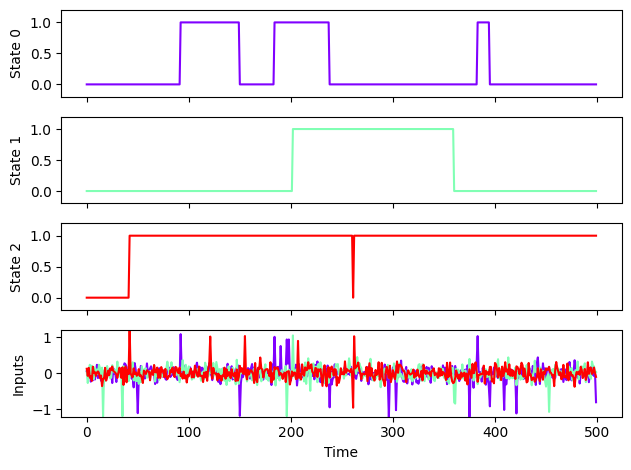

In [2]:
from interpretability.task_modeling.task_env.task_env import NBitFlipFlop

n = 3
trial_length = 500
switch_prob = 0.01
noise = 0.15

env_3bff = NBitFlipFlop(
    n = n, 
    n_timesteps=trial_length, 
    switch_prob=switch_prob, 
    noise=noise
    )

env_3bff.render()

Above, we are plotting the inputs and outputs of the 3BFF task. One trial is 500 time steps, each with a 1% probability of getting an "up" or "down" pulse on each of its 3 input channels. When the task receives an "up" pulse, the state corresponding to that input channel moves from zero to one (if possible), and if a state at one receives a "down" pulse, it goes to zero. In this way, this system acts as 3 bits of memory, encoding 8 potential system states (2^3 states). We add noise to the inputs of the system so that it better reflects realistic computations that a neural circuit might perform.

Another way to visualize this is to view the three states in 3D. Below you can see that the 8 potential states appear as the vertices of a cube. Each trial is plotted as column. 

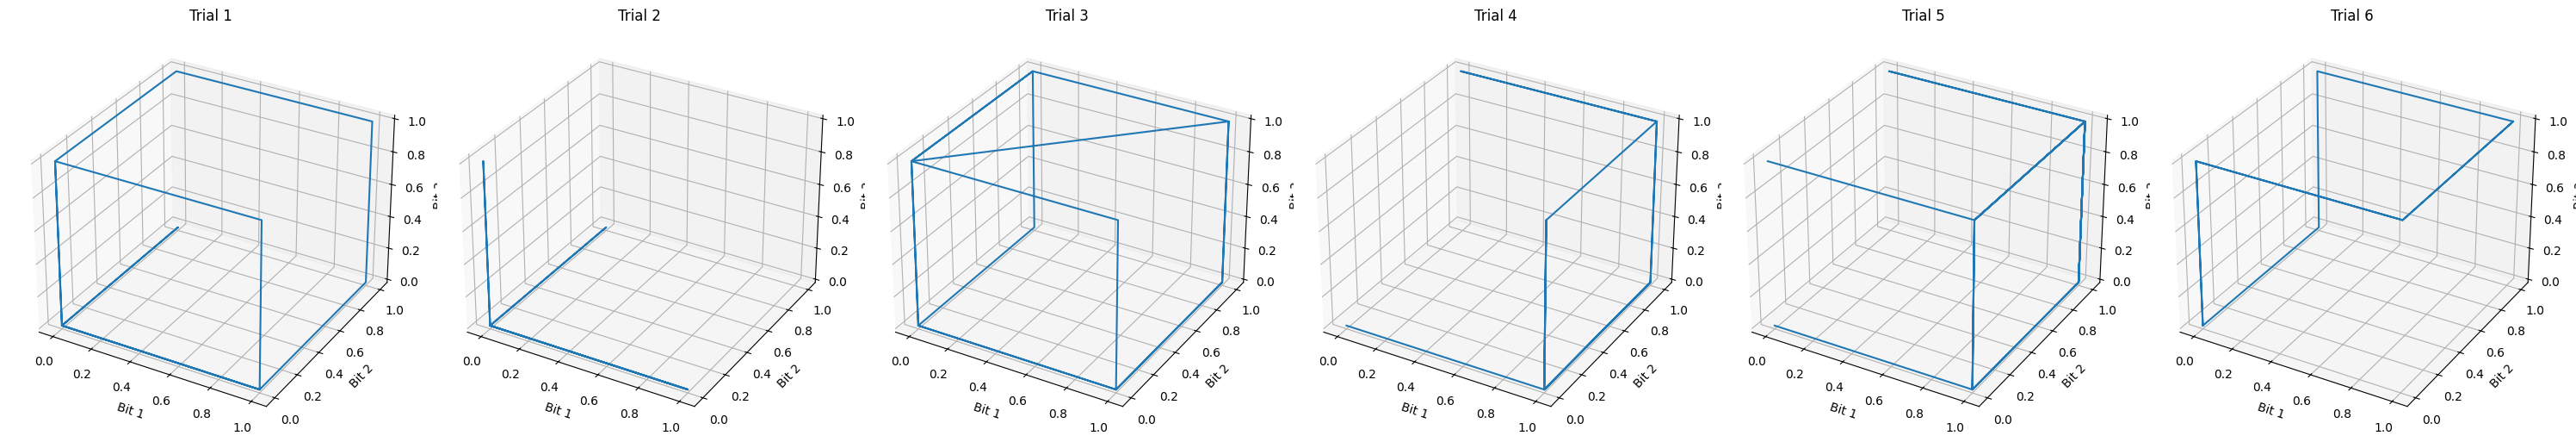

In [3]:
env_3bff.render_3d(n_trials=6)

Now that we can see the basic logic of the task, let's do a basic overview of what task-training is!

<img src="png/TTModelExample-01.png" width="600"/>

For task-training, we are simply training a model (e.g., an RNN) to produce a set of outputs given a set of inputs. This input/output relationship defines the task that the model is performing. In the case of 3BFF, an input pulse should cause the model's output to change in a way that reflects the switching of a bit.

### 3BFF Loss Function:
The 3BFF model was trained to minimize the MSE between the desired output and the output of the model, with the following qualification: The loss contributions of a given bit were zeroed in a short window after that bit received an input pulse. This reduces the stiffness of the learned dynamics and leads to simpler fixed-point structures.

For this tutorial, we are using the pre-trained models provided with the benchmark, but you can train your own models using ./examples/run_task_training.py

### Loading pre-trained models:

To inspect these models, we're going to use an Analysis object, which is a tool included in the benchmark that makes the models easier to work with. Point the initialization at the folder where the saved model and datamodule live, and it will load them into a single object. 

Analysis objects contain methods that help inspect the features of the task-trained model, and provide a few useful functions for visualizing and interpreting the latent activity.

This model was a GRU RNN trained with the following hyperparameters: (see interpretability/task_modeling/configs/ for full parameter list)
- Hidden Size: 128
- Learning Rate: 1e-3
- Weight Decay: 1e-6
- Batch Size: 1000
- Number of Epochs: 1000

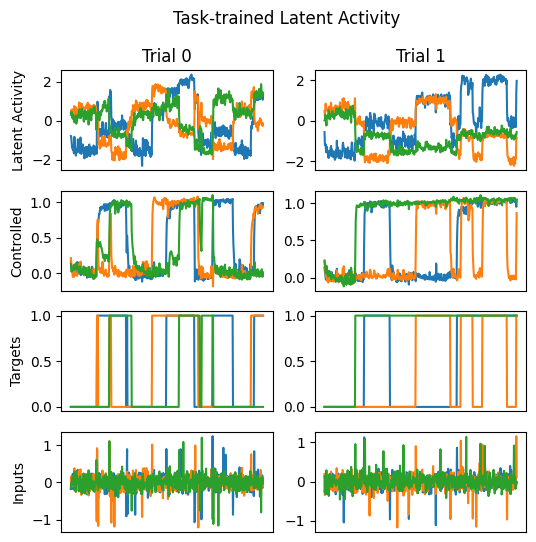

In [3]:
from interpretability.comparison.analysis.tt.tt import Analysis_TT
fpath_3bff = HOME_DIR + "content/benchmark_datasets/pretrained/tt/3BFF/"
# Create the analysis object:
analysis_tt_3bff = Analysis_TT(
    run_name = "tt_3BFF_pretrained", 
    filepath = fpath_3bff)

analysis_tt_3bff.plot_trial_io(num_trials=2)

Inspecting the latent activity, the outputs, and the targets, we can see that the model is doing a pretty good job at producing outputs that match the targets, even in the presence of pretty noisy inputs.

Looking at the scree plot (the % of variance explained by each of the principal components), we can see that the vast majority of the latent activity falls within the first 3 dimensions of the GRU.

array([0.36991445, 0.28086747, 0.25204119, 0.02286715, 0.01728337,
       0.01466676, 0.01293174, 0.00753582, 0.00579525, 0.00453261])

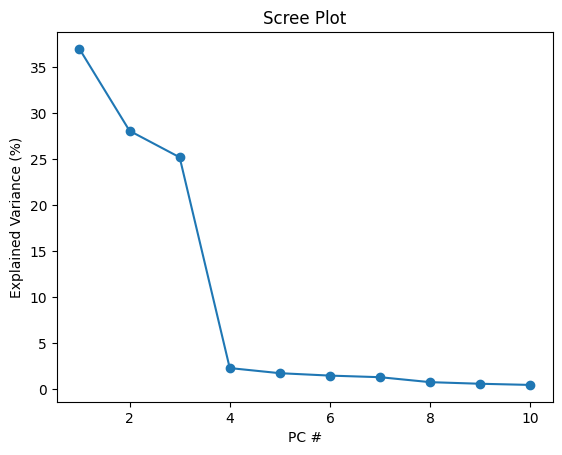

In [4]:
analysis_tt_3bff.plot_scree()

Finally, we can use fixed-point finding to inspect the linearized dynamics of the trained model.
Fixed points are points in the dynamics for which the flow field is zero, meaning that points at that location do not move.

We use a modified version of a fixed point finder released by Golub et al. XXXX to search the flow field for these zero points.

Try changing some of these parameters: 
- How quickly are the fixed-points found in the model?
- How many initializations are needed to find the fixed points?
- Do the stability properties tell us anything about the underlying computation?


Iteration 500/30000
q = 4.91E-03 +/- 3.02E-02
dq = 1.02E-05 +/- 6.19E-05

Iteration 1000/30000
q = 2.21E-03 +/- 1.53E-02
dq = 2.48E-06 +/- 1.55E-05

Iteration 1500/30000
q = 1.41E-03 +/- 1.11E-02
dq = 1.09E-06 +/- 7.59E-06

Iteration 2000/30000
q = 9.53E-04 +/- 8.23E-03
dq = 8.14E-07 +/- 6.64E-06

Iteration 2500/30000
q = 5.82E-04 +/- 5.29E-03
dq = 6.34E-07 +/- 6.11E-06

Iteration 3000/30000
q = 3.31E-04 +/- 3.12E-03
dq = 3.75E-07 +/- 3.91E-06

Iteration 3500/30000
q = 1.95E-04 +/- 2.00E-03
dq = 1.91E-07 +/- 1.92E-06

Iteration 4000/30000
q = 1.21E-04 +/- 1.31E-03
dq = 1.18E-07 +/- 1.41E-06

Iteration 4500/30000
q = 7.21E-05 +/- 6.77E-04
dq = 7.59E-08 +/- 1.23E-06

Iteration 5000/30000
q = 4.62E-05 +/- 3.94E-04
dq = 3.39E-08 +/- 3.49E-07

Iteration 5500/30000
q = 3.29E-05 +/- 2.73E-04
dq = 2.12E-08 +/- 2.08E-07

Iteration 6000/30000
q = 2.42E-05 +/- 1.94E-04
dq = 1.41E-08 +/- 1.34E-07

Iteration 6500/30000
q = 1.83E-05 +/- 1.42E-04
dq = 9.75E-09 +/- 8.83E-08

Iteration 7000/30000
q = 

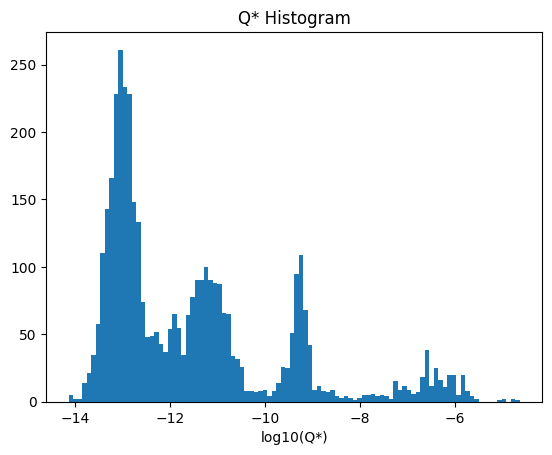

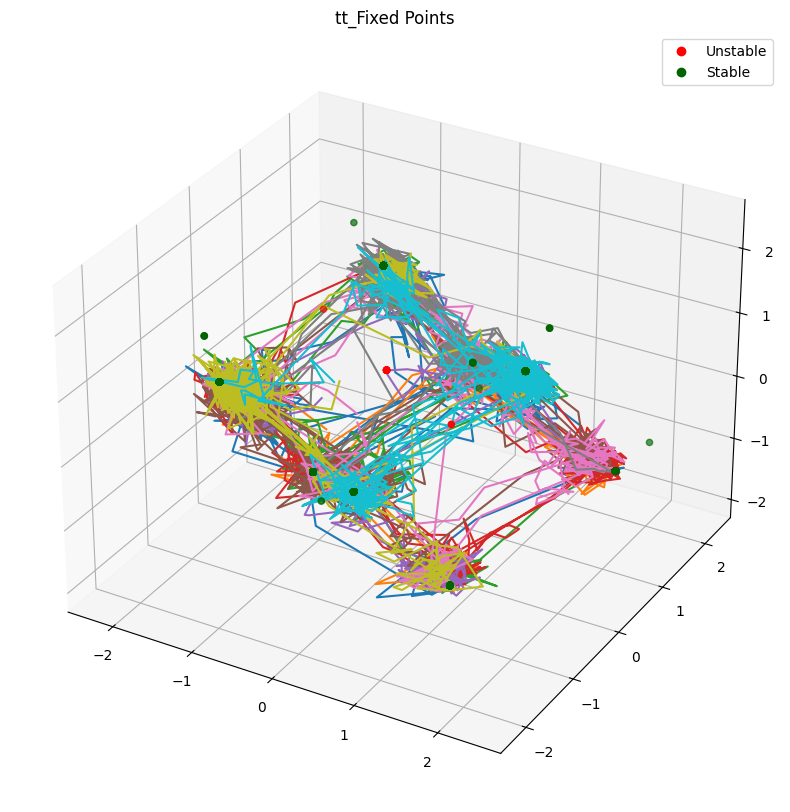

In [5]:
fps = analysis_tt_3bff.plot_fps(
    inputs=None,
    n_inits=4048,
    learning_rate=1e-3,
    noise_scale=0.05,
    max_iters=30000,
    seed=0,
    compute_jacobians=True,
    q_thresh=1e-10,
    )

## Task 2: MultiTask:
The second task included in the benchmark is adapted from Laura Driscoll's network in this paper (LINK). 

This network is trained to perform 15 different tasks, some of which share computational features such as memory and a variable response direction. 

The dataset used to train the RNN has 2000 trials per task, but the simulated data only has 500 trials per task to make the trial counts more biologically plausible.

The loss function of this task minimizes the MSE between the output targets and the model outputs, weighted according to the trial phases. Additionally, losses immediately after the response signal are ignored. See /interpretability/task_modeling/task_env/loss_func.py for the full implementation details.

Importantly, the trial lengths can vary substantially between task types and trials, so your data-trained models need to be able to handle dissimilar trial lengths!

The particulars of all of these tasks are beyond the scope of this tutorial, so we'll just take two of the tasks as examples to demonstrate the basic features of this dataset

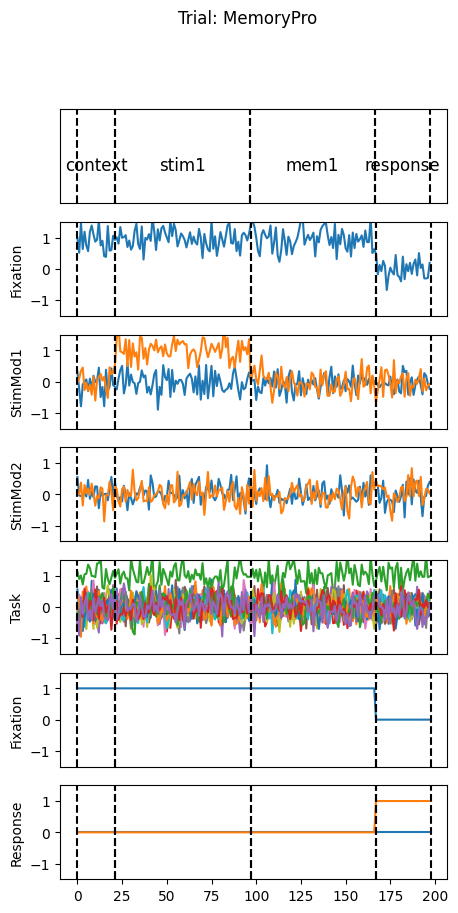

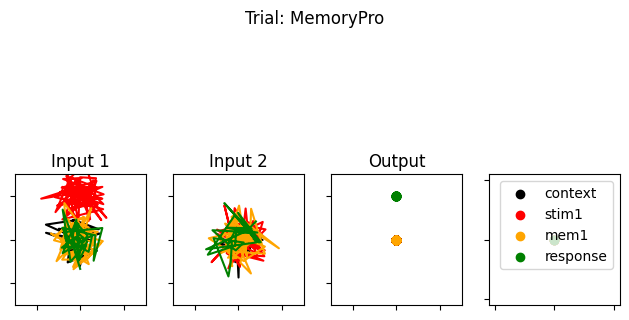

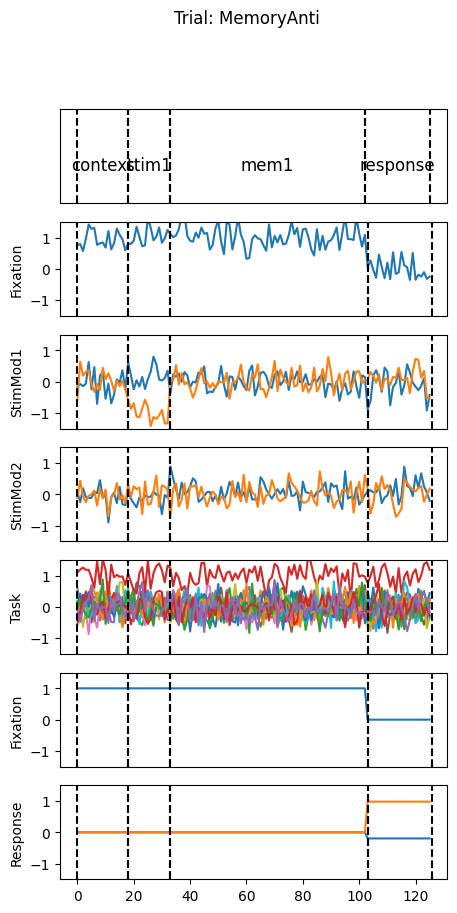

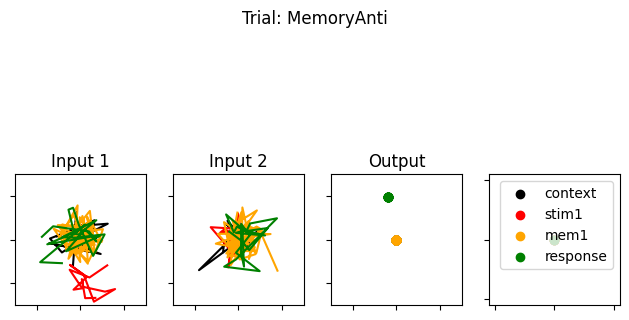

In [ ]:
from interpretability.task_modeling.task_env.multi_task_env import MultiTaskWrapper

multitask = MultiTaskWrapper(
    task_list = [
        "MemoryPro",
        "MemoryAnti",
    ],
    noise = 0.3,
    num_targets = 32,
    bin_size=20,
    n_timesteps= 640,
)

multitask.plot_tasks()


Looking at the plots, we can see that there are 4 phases to both MemoryPro and MemoryAnti:
1. context: In this phase, a one-hot encoding of the task (15 total task inputs) is fed to the model to indicate how the network is meant to process the inputs.
2. stim1: In this phase, a 2D input stimulus is fed into the Input 1 channels (x, y coordinates). Being memory tasks, both models are asked to remember this input.
3. mem1: In this phase the input stimulus returns to zero, and the model needs to remember what input it saw.
4. response: In this phase, the network responds. In the case of MemoryPro, it moves in the direction of the input stimulus. In the case of MemoryAnti, it moves in the opposite direction.

Now let's load up our pre-trained RNN that has learned to do MultiTask!

In [1]:
import dotenv
import pathlib
import os
dotenv.load_dotenv(override=True)
HOME_DIR = os.getenv("HOME_DIR")
print(HOME_DIR)
from interpretability.comparison.analysis.tt.tasks.tt_MultiTask import Analysis_TT_MultiTask
# Create the analysis object:
fpath_multitask = HOME_DIR + "content/benchmark_datasets/pretrained/tt/MultiTask/"
analysis_tt_multitask = Analysis_TT_MultiTask(
    run_name = "tt_MultiTask_pretrained", 
    filepath = fpath_multitask)

/home/csverst/Github/InterpretabilityBenchmark/


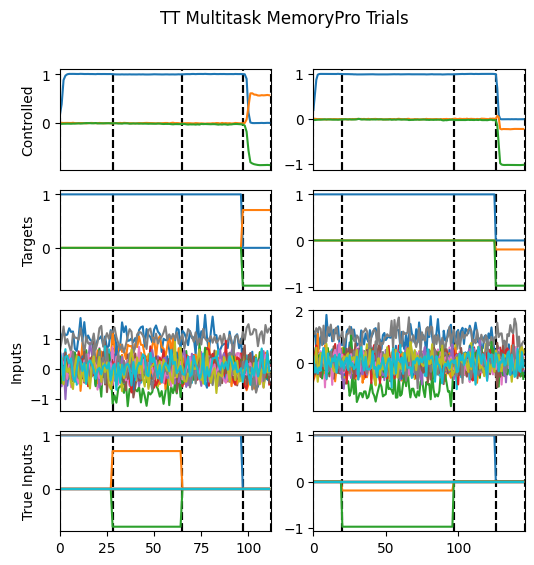

In [3]:
analysis_tt_multitask.plot_task_trial(task= "MemoryPro", num_trials=2)

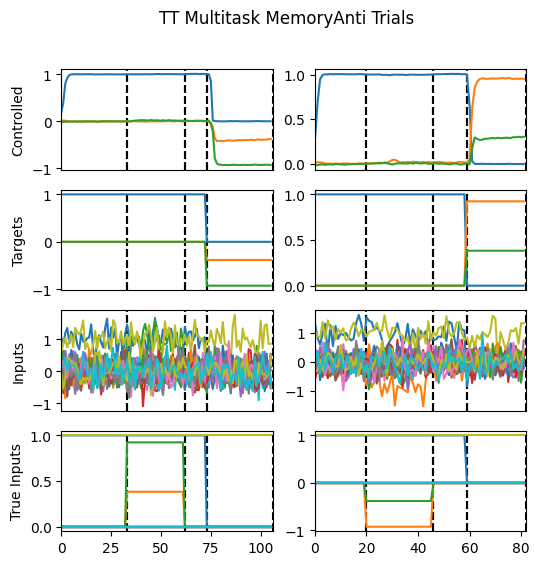

In [6]:
analysis_tt_multitask.plot_task_trial(task= "MemoryAnti", num_trials=2)

First, we can see that in the MemoryPro task, the model is reaching in the same direction as the inputs, while in the MemoryAnti it is reaching in the opposite direction.  

Second, we can see that our model seems to be performing both tasks pretty well (comparing Targets to Controlled).

Can we now use our FixedPoint finding to say anything about the underlying dynamics?

Importantly, fixed points are only meaningful in a regime where the inputs are stable, so let's pick the MemoryPro task and the memory phase for our FP analysis.

Computing fixed points for context using ['context', 'mem1']



Iteration 500/10000
q = 4.84E-04 +/- 1.31E-03
dq = 1.23E-06 +/- 3.61E-06

Iteration 1000/10000
q = 2.00E-04 +/- 5.15E-04
dq = 2.65E-07 +/- 7.17E-07

Iteration 1500/10000
q = 1.15E-04 +/- 2.88E-04
dq = 1.12E-07 +/- 2.90E-07

Iteration 2000/10000
q = 7.46E-05 +/- 1.84E-04
dq = 6.57E-08 +/- 1.53E-07

Iteration 2500/10000
q = 5.21E-05 +/- 1.27E-04
dq = 4.78E-08 +/- 1.06E-07

Iteration 3000/10000
q = 3.80E-05 +/- 9.10E-05
dq = 4.46E-08 +/- 9.26E-08

Iteration 3500/10000
q = 2.87E-05 +/- 6.72E-05
dq = 4.29E-08 +/- 9.37E-08

Iteration 4000/10000
q = 2.21E-05 +/- 5.06E-05
dq = 4.29E-08 +/- 9.57E-08

Iteration 4500/10000
q = 1.74E-05 +/- 3.87E-05
dq = 3.83E-08 +/- 8.69E-08

Iteration 5000/10000
q = 1.39E-05 +/- 2.99E-05
dq = 4.29E-08 +/- 1.10E-07

Iteration 5500/10000
q = 1.12E-05 +/- 2.32E-05
dq = 3.63E-08 +/- 8.94E-08

Iteration 6000/10000
q = 9.20E-06 +/- 1.81E-05
dq = 4.36E-08 +/- 1.12E-07

Iteration 6500/10000
q = 7.62E-06 +/- 1.42E-05
dq = 3.67E-08 +/- 9.27E-08

Iteration 7000/10000
q = 

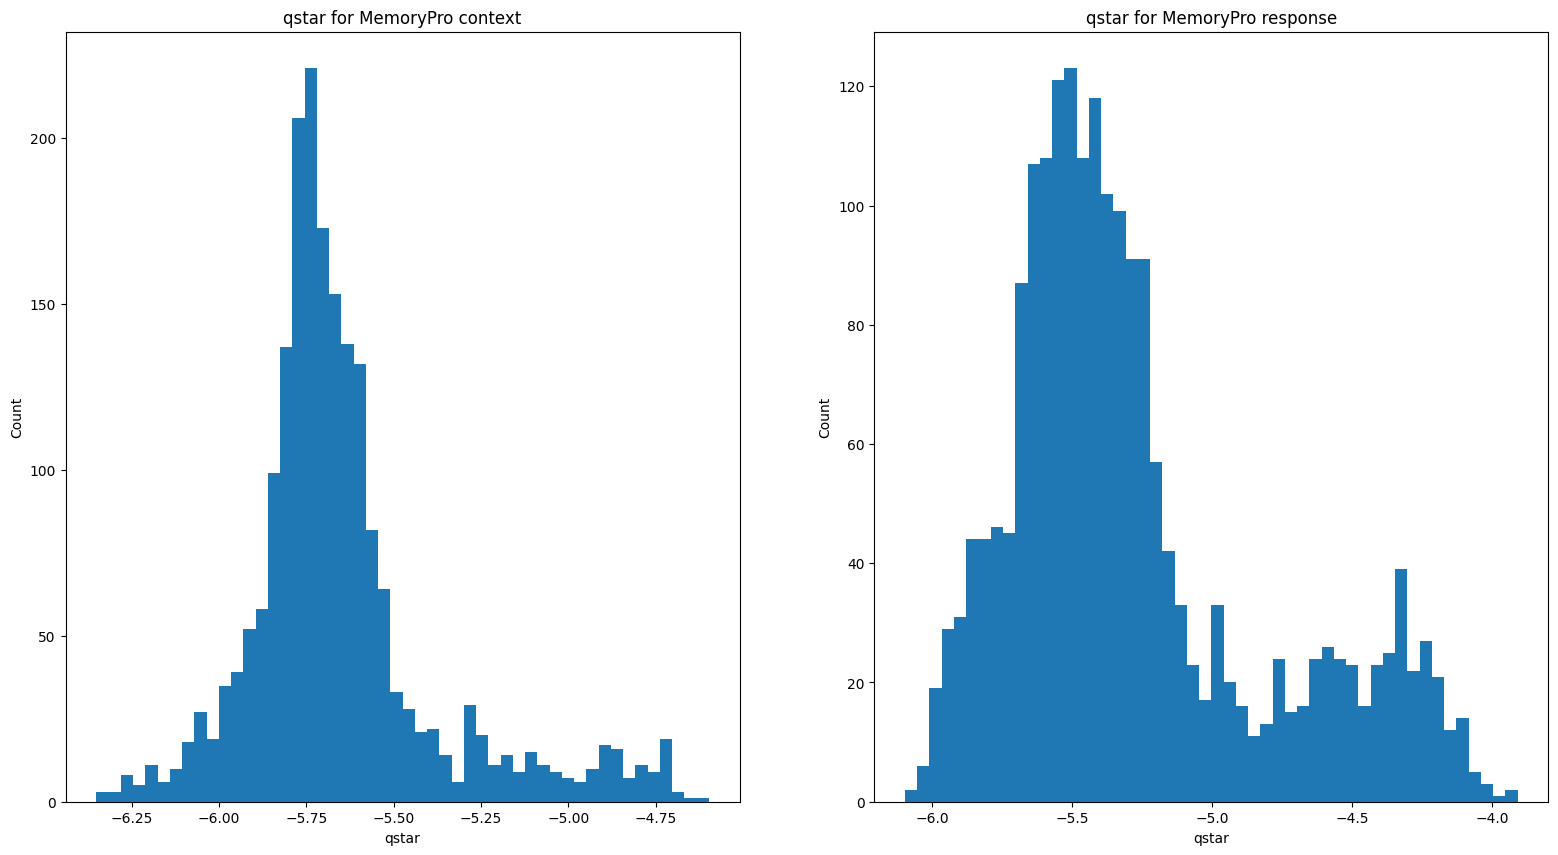

In [29]:
import torch
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

fps = {}
xstar_pca = []
fps_out = []
q_star = []
num_phases = 4
task_to_analyze = "MemoryPro"
phase_names = ['context', 'response']
phase_list = [['context', 'mem1'],'response']
pca = PCA(n_components=2)
readout = analysis_tt_multitask.wrapper.model.readout
# For each phase, compute the fixed points
for i, phase_for_fp in enumerate(phase_list):
    print(f"Computing fixed points for {phase_names[i]} using {phase_for_fp}")
    # Returns fps and x_trajs in the original space
    fps[phase_names[i]]= analysis_tt_multitask.compute_fps_phase(
        phases=phase_for_fp, 
        task_to_analyze="MemoryPro", 
        noise_scale=0.01, lr = 1e-3, 
        max_iters = 10000, use_noisy = False
        )
    # Transform the fps and x_trajs into the PCA space
    xstar= fps[phase_names[i]].xstar
    xstar_pca.append(pca.fit_transform(xstar))
    fps_out.append(readout(torch.Tensor(xstar)).detach().numpy())
    q_star.append(fps[phase_names[i]].qstar)
xstar_pca = np.stack(xstar_pca, axis = 0)
fps_out = np.stack(fps_out, axis = 0)
fps_mat = np.concatenate((xstar_pca[:,:,:2], fps_out[:,:,1:2]), axis=2)
q_star = np.stack(q_star, axis = 0)
# Set values of qstar that are zero to 1e-16 for plotting
q_star[q_star == 0] = 1e-16
fig = plt.figure(figsize=(10*num_phases, 10))
for i, phase in enumerate(phase_names):
    # Add histogram of qstar
    ax = fig.add_subplot(1, num_phases, i+1)
    ax.hist(np.log10(q_star[i]), bins=50)
    ax.set_xlabel("qstar")
    ax.set_ylabel("Count")
    ax.set_title(f"qstar for {task_to_analyze} {phase}")
plt.show()


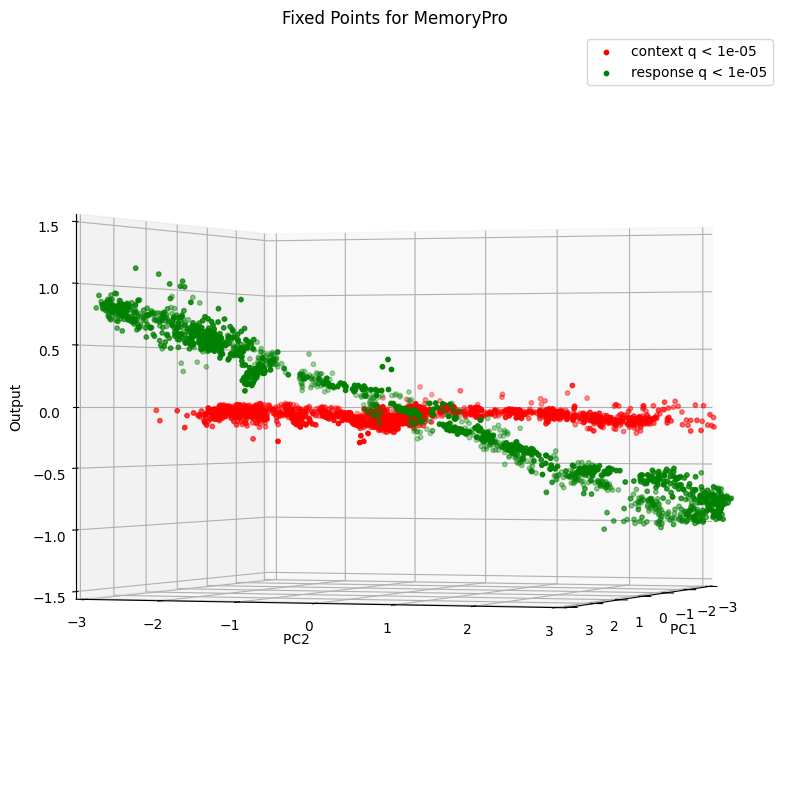

In [30]:
# window to only FPs whose q values are less than thresh
fps_plot = fps_mat.copy()
threshs = [1e-5, 1e-5]
colors = ['r', 'g']
for i, phase in enumerate(phase_names):
    q_flag = q_star[i] < threshs[i]
    fps_plot[i, ~q_flag, :] = np.nan

# combine lats_pca 1 and 2 and output 1
fig = plt.figure(figsize=(10*num_phases, 10))
ax = fig.add_subplot(1, 1, 1, projection="3d")
for i, phase in enumerate(phase_names):
    ax.scatter(
        fps_plot[i,:,0], 
        fps_plot[i,:,1], 
        fps_plot[i,:,2], 
        s=10, c=colors[i],
        label = f"{phase} q < {threshs[i]}"
        )
    ax.set_xlabel(f"PC1 ")
    ax.set_ylabel(f"PC2 ")
    ax.set_zlabel("Output")
    ax.set_title(f"Fixed Points for {task_to_analyze}")
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    ax.set_zlim([-1.5, 1.5])
    ax.legend()
    # Set view
    ax.view_init(0, 20)

As expected, we see that this model performs the task by placing a ring of fixed points that have zero projection onto the output decoder during the context and memory phases.

When the reponse phase begins, this ring rotates into the readout-potent space!

Overall, the multi-task dataset shows interesting dynamics with interpretable fixed-point structures that our data-trained models will hopefully be able to reconstruct!

# Task 3: Random Target:
The final task is a random-target reaching task performed by an RNN controlling a 2-joint musculoskeletal model of an arm actuated by 6 Mujoco muscles. This environment was built using MotorNet, a musculoskeletal modeling package developed by Codol et al. 

Behaviorally, the task has the following structure:
1. A random initial hand position is sampled from a range of reachable locations; the model is instructed to maintain that hand position.
2. A random target position is chosen from the range of reachable locations and fed to the model.
3. After a random delay period, a go-cue is fed to the model, which prompts the model to generate muscle activations that drive the hand to the target location.
4. On 20% of trials, the go-cue is never supplied ("catch" trials)
5. On 50% of trials, a randomly directed bump perturbation (5-10 N, 150-300 ms duration) is applied to the hand.
    - 50% of these bumps occur in a small window after the go-cue
    - 50% of these bumps occur at a random time in the trial


In [33]:
from interpretability.comparison.analysis.tt.tt import Analysis_TT
# Create the analysis object:

fpath_RT = HOME_DIR + "content/benchmark_datasets/pretrained/tt/RandomTarget/"
analysis_tt_RT = Analysis_TT(
    run_name = "tt_MultiTask_pretrained", 
    filepath = fpath_RT)

In [ ]:
analysis_tt_RT.plot_trial_io(num_trials=2)

<img src="png/FinalGif.gif" width="300"/>

## Task 3: RandomTarget

The final task uses MotorNet, a musculoskeletal modeling package developed by Oli Codol, to simulate

## Implementations of data-trained models:
- Basic Sequential Auto-Encoders (SAEs)
- Latent Factor Analysis via Dynamical Systems (LFADS)
- Jacobian Switching Linear Dynamical Systems (JSLDS, in development)

To demonstrate the usefulness of the benchmark, we're going to:
1. Load a task-trained network pre-trained to perform the 3-Bit Flip-Flop task.
2. Load a data-trained network pre-trained on the simulated data.
3. Visualize the dynamics of the task-trained and data-trained networks with fixed point analysis and 
4. Compare the dynamics of our data-trained models to the underlying dynamics of the task-trained network!

# Step 1: Task-Training
Let's begin by picking a simple task that we can train a model to perform.

![Easter Egg](png/TaskEnvs-01.png)

## N-Bit Flip-Flop
We're going to start out with the task that helped to launch this whole field, the N-Bit Flip-Flop. Sussillo et al. XXX used the three-bit flip-flop their seminal attempts to understand how dynamics can give rise to computation! 

The code snippet below intantiates an "TaskEnv" object, which contains the logic for the NBFF task. See the task_env documentation for more information on the requirements for creating your own task environments!

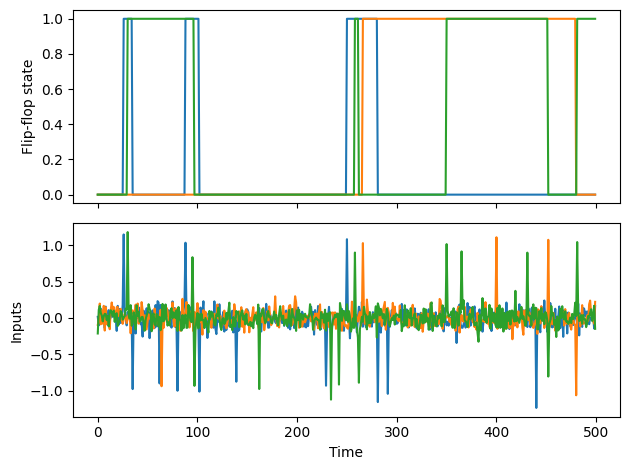

In [ ]:
from interpretability.task_modeling.task_env.task_env import NBitFlipFlop

env_3bff = NBitFlipFlop(n = 3, n_timesteps=500, switch_prob=0.01, noise=0.1)
env_3bff.render()

Above, we are plotting the inputs and outputs of the 3BFF task. One trial is 500 time steps, each with a 1% probability of getting an "up" or "down" pulse on each of its 3 input channels. When the task receives an "up" pulse, the state corresponding to that input channel moves from zero to one (if possible), and if a state at one receives a "down" pulse, it goes to zero. In this way, this system acts as 3 bits of memory, encoding 8 potential system states (2^3 states). We add noise to the inputs of the system so that it better reflects realistic computations that a neural circuit might perform.

Another way to visualize this is to view the three states in 3D. Below you can see that the 8 potential states appear as the vertices of a cube. Each trial is plotted column. 

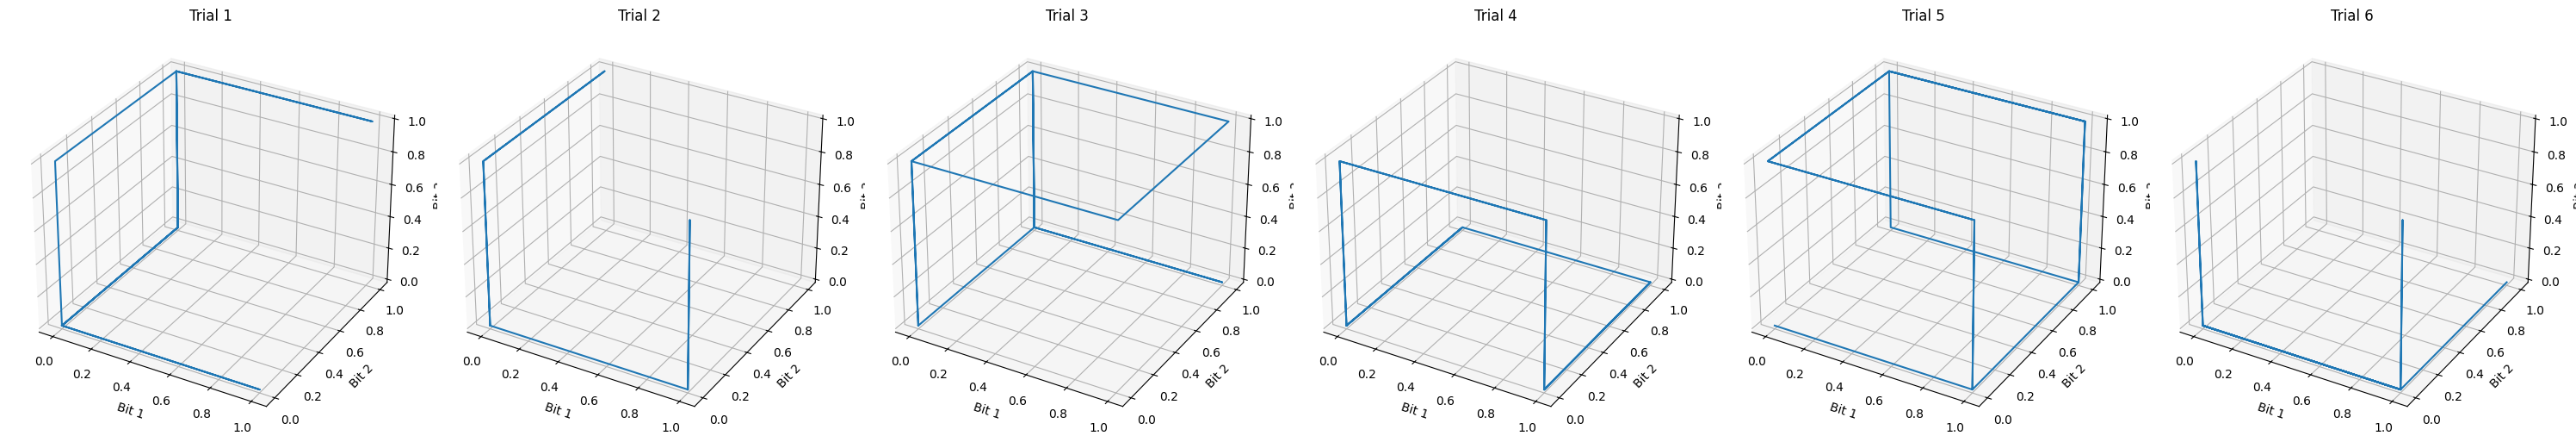

In [ ]:
env_3bff.render_3d(n_trials=6)

Now that we've explored our task, let's train a model to perform it!

We use PyTorch Lightning to simplify this process, abstracting most of the training loop engineering so we can just deal with the models and tasks that we want to test. In general, PyTorchLightning takes in two objects, the LightningModule and the LightningDataModule which are provided by the Benchmark code-base. The only thing that you need to do is define your model class and your task environment.

The task environment is easy: we've defined the logic for the 3-bit Flip-Flop for you, but incorporating new tasks is simple!

In [ ]:
# Create the task environment:
env_3bff = NBitFlipFlop(n = 3, n_timesteps=500, switch_prob=0.01, noise=0.1)
input_size = env_3bff.observation_space.shape[0] + env_3bff.context_inputs.shape[0]
output_size = env_3bff.action_space.shape[0]

In [ ]:

from interpretability.task_modeling.datamodule.task_datamodule import TaskDataModule
from interpretability.task_modeling.task_wrapper.task_wrapper import TaskTrainedWrapper
from interpretability.task_modeling.callbacks.callbacks import StateTransitionTutorialCallback
from pytorch_lightning.loggers.tensorboard import TensorBoardLogger

import pytorch_lightning as pl

# Create the task datamodule:
dm = TaskDataModule(env_3bff, n_samples = 1000, batch_size = 1000)

# Create the task wrapper and set the environment and model:
wrapper = TaskTrainedWrapper(learning_rate=1e-3, weight_decay=1e-6)
wrapper.set_environment(env_3bff)
wrapper.set_model(model)

# Create the task callback and the tensorboard logger:
lg = TensorBoardLogger(save_dir="logs/", name="my_model")
cb = StateTransitionTutorialCallback(log_every_n_epochs=10)

# Train the task model:
trainer = pl.Trainer(max_epochs=10, callbacks=[cb], enable_progress_bar=False)
trainer.fit(wrapper, dm)

NameError: name 'model' is not defined

To look at some tensorboard plots, open a terminal, navigate to the correct folder in lightning_logs, and enter tensorboard --logdir .

Once your model is done training, it should look something like this:
![Easter Egg](png/state_plot.png)

Unsurpisingly, with so few epochs of training, it doesn't look very good. Don't worry, we're going to pull in some pre-trained models so that our simulated brain can actually remember 3 bits :D

Let's see how well the model can perform the 3BFF task!

To do this, we're going to skip ahead a little bit and take a sneak peek at the Analysis class, which abstracts away much of the complexity of dealing with the models.

In [ ]:
from interpretability.comparison.analysis.tt.tt import Analysis_TT

# Create the analysis object:
analysis = Analysis_TT(
    run_name = "tt_3BFF_pretrained", 
    filepath = "./pretrained_tt/")
analysis.plot_trial(num_trials=3, scatterPlot=False)

wrapper = analysis.wrapper

Top row represents the top 3 PCs of the latent activity
Middle row is the controlled output (what the model is attempting to match the targets)
Bottom row are the targeted control values.

As we can see, the model seems to be doing a pretty good job, but there seems to be things happening in the latent activity that are not reflected in the output.
Seems like this could potentially be an interesting dataset to examine!

# Step 2: Neural Data Simulation

Now that we have our RNN that is trained to perform three-bit flip-flop, we need to simulate the neural spiking activity.
For that, we are going to use the next object, called the Neural Data Simulator.

![Easter Egg](png/BenchmarkSchematicSimpleNeuralDS-01.png)

The neural data simulator is very simple; it takes in a datamodule and the trained model, and saves an .h5 file of neural firing rates to a location in your local directory where the data-trained models will be able to find it.

The process of simulating neural data has two steps:
1. Instantiate NeuralDataSimulator object with simulation parameters.
2. Pass the trained TT model, the datamodule that you want to simulate neural activity from, and some file paths to the simulate_neural_data method.

In the full code, the simulator is saved with the task-trained model so more neural activity can be simulated later if needed. Importantly, the datamodule used for simulation doesn't need to be the same datamodule used to train the model; this means allow for easy testing of generalizability of task-trained models.

Below is a schematic of the data simulation pipeline. See neural_simulator.py for information on the parameters and options for simulation.
![simulation](png/SimulationDiagram.png)

In [ ]:
from interpretability.task_modeling.simulator.neural_simulator import NeuralDataSimulator
dm_sim = TaskDataModule(env_3bff, n_samples = 1000, batch_size = 1000, seed= 4096)
dm_sim.prepare_data()
dm_sim.setup()


dataset_path = pathlib.Path(HOME_DIR, "content", "datasets", "dt")
# Create the neural data simulator:
simulator = NeuralDataSimulator(
    n_neurons = 50,
    nonlin_embed=False,
)

simulator.simulate_neural_data(
    task_trained_model=wrapper,
    datamodule= dm_sim,
    run_tag = "tt_3BFF_pretrained",
    subfolder="seed=4096",
    dataset_path= dataset_path,
    seed= 4096,
)

![Data-training](png/BenchmarkSchematicSimpleDT-01.png)

In [ ]:
from interpretability.data_modeling.datamodules.SAE.task_trained_data import TaskTrainedRNNDataModule
from interpretability.data_modeling.models.SAE.dyn_models_GRU import GRULatentSAE
import pickle
TRAINED_PATH = (
    "/home/csverst/Github/InterpretabilityBenchmark/content/"
    "trained_models/task-trained/20240225_NBFF_GRU_Tutorial/max_epochs=1000 seed=0/"
    )
# Create the datamodule:
dt_datamod = TaskTrainedRNNDataModule(prefix = "tt_3BFF_pretrained", system = "3BFF", gen_model="GRU_RNN", seed=4096)

# Create the model:
model = GRULatentSAE(
    dataset = "3BFF",
    encoder_size = 64,
    encoder_window = -1,
    heldin_size = 50,
    heldout_size= 50,
    latent_size= 128,
    lr = 1e-3,
    weight_decay = 1e-6,
    dropout = 0.05,
    input_size=3,
)

# Create the task callback and the tensorboard logger:
lg = TensorBoardLogger(save_dir="logs/", name="my_model_dt")

# Train the task model:
trainer = pl.Trainer(max_epochs=10, enable_progress_bar=False)
trainer.fit(wrapper, dm)

# Save the model and the datamodule as a pkl file:
dt_path = pathlib.Path(TRAINED_PATH, "dt")
os.mkdir(dt_path)

with open(os.path.join(dt_path, 'model.pkl'), "wb") as f:
    pickle.dump(model, f)

with open(os.path.join(dt_path, 'datamodule.pkl'), "wb") as f:
    pickle.dump(dt_datamod, f)
    

![comps](png/BenchmarkSchematicSimpleComparisons-01.png)

In [ ]:
from interpretability.comparison.analysis.dt.dt import Analysis_DT
from interpretability.comparison.analysis.tt.tt import Analysis_TT

# Create the analysis object:
analysis_tt = Analysis_TT(
    run_name = "tt_3BFF_pretrained", 
    filepath = "./pretrained/tt/")

analysis_dt = Analysis_DT(
    run_name = "dt_3BFF_pretrained", 
    filepath = "./pretrained/dt/20240226_NBFF_GRU_DT/")


In [ ]:
from interpretability.comparison.comparison import Comparison
comparison = Comparison()
comparison.load_analysis(analysis_tt, reference_analysis=True)
comparison.load_analysis(analysis_dt)

comparison.plot_trials_reference(num_trials=3)

In [ ]:
comparison.compare_state_r2()

In [ ]:
comparison.compare_rate_r2()

In [ ]:
analysis_dt.plot_fps(max_iters=30000,q_thresh=1e-7)

In [ ]:
comparison.compare_dynamics_DSA(
    n_delays = 50, 
    rank = 200,
    percent_data=0.1,
    )